In [1]:
from neuron import h, gui, load_mechanisms
from nrnutils import Section, Mechanism
import numpy as np

In [2]:
# It is not possible to consistently get the path of a Jupyter notebook. But this may work most of the time.
# If not, paste the absolute path to the folder containing the mod files (not the compiled files)
import os
current_path = os.getcwd()
load_mechanisms(os.path.join(current_path, "mod"))

True

In [3]:
# Parameters 

myena = 55
myek = -97

nax_bouton = 1000 
nax_axon = 0

Kv1_bouton = 2000 
Kv1_axon = 0

leakK_bouton = 0.18 #.08
leakK_axon = leakK_bouton/10

leakNa_bouton = leakK_bouton/13
leakNa_axon = leakNa_bouton/10



#ih_bouton = 0.00003
#ih_axon = ih_bouton/10
#ih_e = -23
#ih_k_na_ratio = (myena-ih_e)/(myena-myek)

#charge_start = 1000
#charge_end = 1030

#vShift_Kv1 = 25
#vShift_inact_Kv1 = -15
#speed_Kv1 = 2.3
#vShift_nax = 20         # Global variable accessible with h.vShift_nax
#vShift_inact_nax = 10    # Local variable accessible with some_segment(0.5).vShift_inact_local
#q10_nax = 4
#q10h_nax = 4
        


In [4]:
class AxonWithBoutons(object):
        
    def __init__(self, axNum=15, axon_mechanisms=list(), bouton_mechanisms=list(), add_charge=True):
        
        self.axNum = axNum
        
        #See comment below on measuring the total ion currents
        #if add_charge:
        #    axon_mechanisms.append(Mechanism("charge_", tmin=charge_start, tmax=charge_end))   
        #    bouton_mechanisms.append(Mechanism("charge_", tmin=charge_start, tmax=charge_end))   
        
        # Define axon
        self.axons = [Section(nseg = 5 if i < axNum else 20, 
                              L = 35 if i < axNum else 150, 
                              diam = 0.8, 
                              cm = 0.9/10,
                              mechanisms=axon_mechanisms)
                 for i in range(axNum+1)]
        
        self.boutons = [Section(nseg=1,
                                L=8,
                                diam=8,
                                cm=0.9,
                                mechanisms=bouton_mechanisms)
                 for i in range(axNum)]

        # Connectivity
        for axon, bouton in zip(self.axons, self.boutons):
            bouton.connect(axon)   # connect bouton 0-end to preceeding axon 1-end
        for bouton, axon in zip(self.boutons, self.axons[1:]):
            axon.connect(bouton(1),0) # connect axon 0-end to preceeding bouton 1-end

        # Someting for all
        h.celsius = 37   
        for section in h.allsec():
            section.Ra = 120     # TODO: There is also an h.global_ra, might use that instead
            section.ena = myena
            section.ek = myek


In [5]:
model = AxonWithBoutons(axon_mechanisms  =[Mechanism('nax', gbar = nax_axon),
                                                      Mechanism('Kv1', gbar = Kv1_axon),
                                                      Mechanism('leakNa', g = leakNa_axon),
                                                      Mechanism('leakK', g = leakK_axon),],
                                   bouton_mechanisms=[Mechanism('nax', gbar = nax_bouton),
                                                      Mechanism('Kv1', gbar = Kv1_bouton),
                                                      Mechanism('leakNa', g = leakNa_bouton),
                                                      Mechanism('leakK', g = leakK_bouton),]
                                  )



In [6]:
# Some special place
first_Bouton = model.boutons[0]
middle_Bouton = model.boutons[model.axNum//2]

# Checking topology
s = h.Shape()
s.show(False)
s.color(2, sec=middle_Bouton)     # color middle_Bouton red
s.color(3, sec=first_Bouton)     # color first_Bouton blue
# h.topology()

0.0

![Shape](shape.jpg)

In [7]:
stim = h.IClamp(first_Bouton(0.5))
stim.delay=11    # stimulus delay in ms
stim.dur=0.5      # stimulus duration in ms
stim.amp=200     # stimulus amplitude in nA

In [8]:
# Record voltage and time
v_vec = h.Vector()          # Membrane potential vector [mV]
t_vec = h.Vector()          # Time stamp vector [ms]
v_vec.record(middle_Bouton(0.5)._ref_v)
t_vec.record(h._ref_t) 

Vector[4]

**Note on how to record the total sodium and potassium current**

https://www.neuron.yale.edu/phpBB/viewtopic.php?t=3844

**Question**: To get the sum of all the ion currents I_ion, can I just record 'segment._ref_ina' and 'segment._ref_ik', multiply them with area, and add them together? Are there other ways to directly get the sum of total ion currents?

**Ted**: Nope, that's the only way. Don't forget to include i_pas and ileak_hh. But you're not going to include pas, so just remember to add ileak_hh

In [9]:
# Record total sodium and potassium current densities at the middle boutonn
ina_vec = h.Vector()        # sodium current density vector [mA/cm ]
ik_vec = h.Vector()         # potassium current density vector [mA/cm2]
ina_vec.record(middle_Bouton(0.5)._ref_ina)   
ik_vec.record(middle_Bouton(0.5)._ref_ik)      

Vector[6]

In [10]:
h.tstop = 20.0
h.run()

0.0

<Figure size 720x360 with 0 Axes>

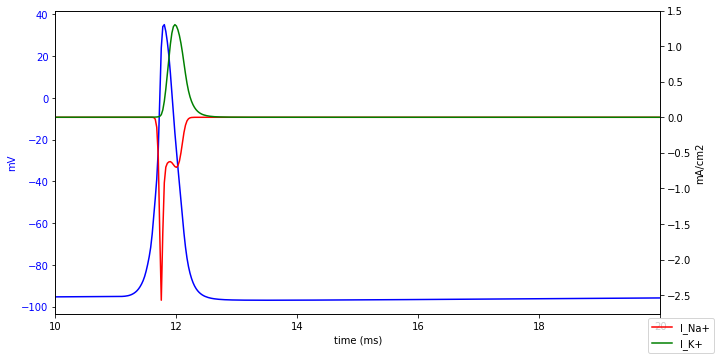

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]


plt.figure() 


fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('mV', color=color)
ax1.plot(t_vec, v_vec, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'black'
ax2.set_ylabel('mA/cm2', color=color)  # we already handled the x-label with ax1
ax2.plot(t_vec, ina_vec, color='red', label='I_Na+')
ax2.plot(t_vec, ik_vec, color='green', label='I_K+')
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_xlim((10,20))   # Discard the first 10s to equilibrate the membrane potential

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc=4)
plt.show()


In [12]:
# Calculate 
print 'time step size = ', h.dt, 'ms'
print 'for one (middle) bouton:'
middle_Bouton_area = middle_Bouton(0.5).area()   
print '   area = ', middle_Bouton_area, 'um2'


I_Na = ina_vec.mul(middle_Bouton_area)   # mA/cm2*um2  = 10^-3 A * 10^+4 * 1^-12 = 10^-11 A
I_Na.mul(0.01)                           # now we have 10^-11 A / 10^-2 = 10^-9 A = nA

print '   maximum sodium current = ', I_Na.min(), 'nA (for sanity check)'

# Integrate sodium current
na_charge = - np.trapz(I_Na, dx=h.dt)   # TODO Integrate only over the action potential

print '   total sodium charge =', na_charge, 'pC' # nA * ms = 10-12 As = 10-12 Coulomb = pC')

factor = 1e-12 * 6.2415090744e18 * 1/3
# pico * number of electrons / coloumb * 1 ATP for pumping 3 Na+

print '   number of ATP per AP = ',  int(factor*na_charge)

time step size =  0.025 ms
for one (middle) bouton:
   area =  201.06192983 um2
   maximum sodium current =  -5.17128358621 nA (for sanity check)
   total sodium charge = 0.7792408272617088 pC
   number of ATP per AP =  1621212
